<a href="https://colab.research.google.com/github/andreafarina/PyTorch_Applications/blob/master/deconvolution_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 25 10:21:13 2020

@author: Andrea Bassi
"""

import torch
from skimage import color, data
from skimage.transform import resize
import matplotlib.pyplot as plt
import scipy.ndimage.filters as fi
import numpy as np
import time

In [0]:
dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print('Using device:', device, '\n')    
 

Using device: cuda 



Integral of the image 12955.228562521961 



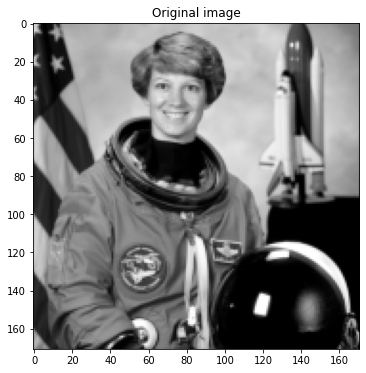

In [0]:
K_SIZE = 13 # PSF size
PADDING = 6 # this should be K_SIZE/2, rounded towards 0
IM_SIZE = 171 # image size

im_np = resize(color.rgb2gray(data.astronaut()), [IM_SIZE,IM_SIZE], mode='constant')
im_np = im_np/np.amax(im_np)
plt.figure(figsize=(6, 6))
plt.gray()
plt.imshow(im_np,vmin=0,vmax=1)
plt.title('Original image')

print('Integral of the image', im_np.sum(),'\n')

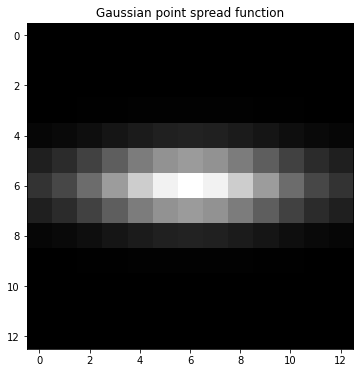

Integral of the PSF 1.0


In [0]:
def gaussian(kernlen, nsig_x, nsig_y):
    inp = np.zeros((kernlen, kernlen))
    inp[kernlen//2, kernlen//2] = 1
    kern = fi.gaussian_filter(inp, (nsig_x, nsig_y))
    scaled_kern = kern / np.sum(kern)
    return scaled_kern

psf_np = gaussian(kernlen=K_SIZE, nsig_x=1, nsig_y=3)

plt.figure(figsize=(6, 6))
plt.imshow(psf_np)
plt.title('Gaussian point spread function');
plt.pause(0.05)


print('Integral of the PSF', psf_np.sum())

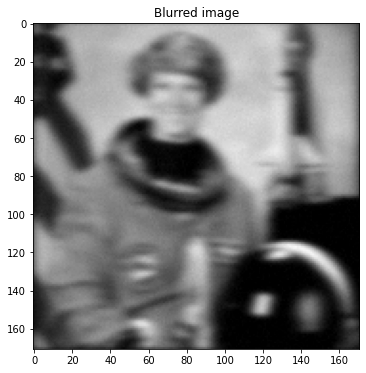

In [0]:
im = torch.from_numpy(im_np).float().to(device = device) 
psf = torch.from_numpy(psf_np).float().to(device = device) 

im = im.expand([1,1,IM_SIZE,IM_SIZE]) 
# don't know why, but I was not able to do the convolution without 
# adding 2 channels with 1 single element 
psf = psf.expand([1,1,K_SIZE,K_SIZE])

# generate blurred images with torch.nn.functional.conv2d
im_blurred = torch.nn.functional.conv2d(im, psf, bias=None, stride=1, padding=PADDING, dilation=1, groups=1).to(device = device)  

# add noise
im_blurred += 0.01* torch.randn(im_blurred.shape).to(device = device) 

plt.figure(figsize=(6, 6))
plt.imshow(im_blurred.squeeze().cpu(),vmin=0,vmax=1) #opposite of expand
plt.title('Blurred image');



# Network definition
> The reconstructed image is stored inside the net and can be called in one of the two following ways:

    net[0].weight
    list(net.parameters())[0].data

> The net has also a bias (of size 1):

    net[1].bias 
    list(net.parameters())[1].data



In [0]:
net = torch.nn.Sequential(
    # torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(1,1,IM_SIZE,1,PADDING).to(device = device)
    # other layers could be added here, separated by comma
)

print('Network structure:\n',net),

params = list(net.parameters())
print('\nNumber of parameters:', len(params))

for index,p in enumerate(params):
   print('\nSize of the parameter', index,':', p.size(),)

# Define a loss function
loss_fn = torch.nn.MSELoss(reduction='sum').to(device = device)
#loss_fn = torch.nn.SmoothL1Loss()

# Use the optim package to define an Optimizer that will update the weights of the model for us. 
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.001)
#optimizer = torch.optim.SGD(net.parameters(), lr=1e-5, weight_decay=0.01)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01, weight_decay=0.01)

Network structure:
 Sequential(
  (0): ConvTranspose2d(1, 1, kernel_size=(171, 171), stride=(1, 1), padding=(6, 6))
)

Number of parameters: 2

Size of the parameter 0 : torch.Size([1, 1, 171, 171])

Size of the parameter 1 : torch.Size([1])


# Deconvolution using iteration

step: 9 ,loss: 3.9690475463867188
step: 19 ,loss: 4.522572040557861
step: 29 ,loss: 4.5652852058410645
step: 39 ,loss: 4.5382161140441895
step: 49 ,loss: 4.929193496704102
step: 59 ,loss: 5.668043613433838
step: 69 ,loss: 5.849124908447266
step: 79 ,loss: 5.5247392654418945
step: 89 ,loss: 5.5454912185668945
step: 99 ,loss: 6.029209613800049
step: 109 ,loss: 6.3521013259887695
step: 119 ,loss: 6.061684608459473
step: 129 ,loss: 5.838010787963867
step: 139 ,loss: 6.076009750366211
step: 149 ,loss: 6.466464996337891
step: 159 ,loss: 6.394495010375977
step: 169 ,loss: 6.093022346496582
step: 179 ,loss: 6.11409854888916
step: 189 ,loss: 6.439393520355225
step: 199 ,loss: 6.5665483474731445
step: 209 ,loss: 6.327559471130371
step: 219 ,loss: 6.195059299468994
step: 229 ,loss: 6.383640289306641
step: 239 ,loss: 6.603756904602051
step: 249 ,loss: 6.5031418800354
step: 259 ,loss: 6.306953430175781
step: 269 ,loss: 6.3508806228637695
step: 279 ,loss: 6.560751914978027
step: 289 ,loss: 6.5949640

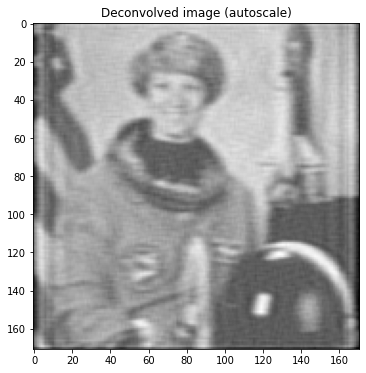

In [0]:
t0 = time.time()

for t in range(300):
     
    # Forward pass: compute predicted blurred image by passing the psf.
        
    im_pred = net(psf)
    
    # Compute and print loss.
    loss = loss_fn(im_pred, im_blurred)#+loss_fn2(im_pred, im_blurred)
        
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()
    
    if t % 10 == 9: #print loss and show image only sometimes
        
        print('step:',t,
              ',loss:', loss.item()
             )
        
        # plt.figure(figsize=(6, 6))
        # plt.title('Deconvolved image, step:' + str(t));  
        # plt.imshow(list(net.parameters())[0].data.squeeze().cpu().numpy(),
        #            vmin=0,
        #            vmax=1)
        # plt.pause(0.05)

plt.figure(figsize=(6, 6))
plt.imshow(net[0].weight.squeeze().detach().cpu().numpy())
plt.title('Deconvolved image (autoscale)');

#del net,im,im_blurred,im_pred
if torch.cuda.is_available():
torch.cuda.empty_cache()
    
    
print('\nElapsed time:', time.time()-t0,'\n')    